In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

In [6]:
df = pd.read_csv('/Users/iMac/Documents/Event datasets/Cosmetic Shop/2019-Dec.csv')

In [7]:
# a quick examination of the dataframe
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df.head(3))

The dataframe has 3533286 rows and 9 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554


In [8]:
# data preparation

# step 1: select customers who purchased
df_sales=df.loc[df.event_type=='purchase',:]

In [9]:
# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
df_sales=df_sales.drop(columns=['category_code','brand','product_id','category_id','user_session'])

In [10]:
# step 3: drop duplicates and negative price
df_sales=df_sales.drop_duplicates()
df_sales=df_sales[df["price"] > 0 ] 

/var/folders/rj/74569_hj08dczy17w0prp9br0000gp/T/ipykernel_57298/2356193662.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sales=df_sales[df["price"] > 0 ]


In [11]:
# step 4: convert "event_time" to DateTime format
df_sales['event_time']=pd.to_datetime(df_sales['event_time'],infer_datetime_format=True)

/var/folders/rj/74569_hj08dczy17w0prp9br0000gp/T/ipykernel_57298/769300188.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_sales['event_time']=pd.to_datetime(df_sales['event_time'],infer_datetime_format=True)


In [12]:
# step 5: null
nullcolumns=df_sales.isnull().sum()
nullnumbers=len(nullcolumns[nullcolumns!=0])

In [13]:
print("After preprocessing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_sales.shape[0],df_sales.shape[1],nullnumbers))
display(df_sales.head(3))

After preprocessing, the dataframe has 150146 rows, 4 columns, and 0 null value.



,event_time,event_type,price,user_id
557,2019-12-01 00:17:50+00:00,purchase,0.38,473613801
560,2019-12-01 00:17:50+00:00,purchase,0.37,473613801
565,2019-12-01 00:17:50+00:00,purchase,0.41,473613801


In [14]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

df_sales.loc[:,'Recency'] = (df_sales["event_time"].max() - df_sales["event_time"]).dt.days
df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})
print(df_R)

         user_id  Recency
0       12055855       11
1       15400971       18
2       25392526       13
3       28129653       21
4       31647175        2
...          ...      ...
25608  595367593        0
25609  595372293        0
25610  595373694        0
25611  595376179        0
25612  595413503        0

[25613 rows x 2 columns]


In [15]:
# step 2: calculate "Frequency"
df_F=df_sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})
print(df_F)

         user_id  Frequency
0       12055855          4
1       15400971          3
2       25392526          3
3       28129653         13
4       31647175          2
...          ...        ...
25608  595367593          4
25609  595372293          2
25610  595373694          1
25611  595376179          9
25612  595413503          1

[25613 rows x 2 columns]


In [16]:
# step 3: calculate "Monetary"
df_M=df_sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})
print(df_M)

         user_id  Monetary
0       12055855     16.54
1       15400971     35.71
2       25392526     22.14
3       28129653     42.85
4       31647175     15.88
...          ...       ...
25608  595367593     21.27
25609  595372293     42.54
25610  595373694     19.83
25611  595376179     46.49
25612  595413503     10.95

[25613 rows x 2 columns]


In [17]:
# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')
print(df_RFM)

         user_id  Recency  Frequency  Monetary
0       12055855       11          4     16.54
1       15400971       18          3     35.71
2       25392526       13          3     22.14
3       28129653       21         13     42.85
4       31647175        2          2     15.88
...          ...      ...        ...       ...
25608  595367593        0          4     21.27
25609  595372293        0          2     42.54
25610  595373694        0          1     19.83
25611  595376179        0          9     46.49
25612  595413503        0          1     10.95

[25613 rows x 4 columns]


In [18]:
print(df_sales[df_sales['user_id'] == 15400971])

                       event_time event_type  price   user_id  Recency
1659356 2019-12-13 12:32:31+00:00   purchase   6.19  15400971       18
1659357 2019-12-13 12:32:31+00:00   purchase  20.00  15400971       18
1663772 2019-12-13 13:12:22+00:00   purchase   9.52  15400971       18


In [ ]:
# step 5: remove outliers before K-Means clustering
# conditions = np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
# df_RFM2=df_RFM.loc[conditions,:]

# df_RFM2.head(3)
# df_RFM2.describe()

In [21]:
# Calculating RFM Scoring

df_RFM.describe()

,user_id,Recency,Frequency,Monetary
count,2.561300e+04,25613.000000,25613.000000,25613.000000
mean,5.215827e+08,15.654316,5.862101,33.844117
std,8.808569e+07,8.200944,5.888677,40.976758
min,1.205586e+07,0.000000,1.000000,0.130000
25%,4.838006e+08,9.000000,2.000000,12.380000
50%,5.584707e+08,15.000000,4.000000,22.850000
75%,5.841410e+08,22.000000,8.000000,40.940000
max,5.954135e+08,30.000000,153.000000,1027.050000


In [22]:
quantiles = df_RFM.quantile(q = [0.25, 0.50, 0.75])
quantiles

,user_id,Recency,Frequency,Monetary
0.25,483800581.0,9.0,2.0,12.38
0.50,558470672.0,15.0,4.0,22.85
0.75,584140950.0,22.0,8.0,40.94


In [23]:
# Creating the RFM Score Segmentation Table

# Recency

def recency_scoring(rfm):
    if rfm.Recency <= 9.0:
        recency_score = 4
    elif rfm.Recency <= 15.0:
        recency_score = 3
    elif rfm.Recency <= 22.0:
        recency_score = 2
    else:
        recency_score = 1
    return recency_score

df_RFM['Recency_Score'] = df_RFM.apply(recency_scoring, axis=1)
df_RFM.sample(10)

,user_id,Recency,Frequency,Monetary,Recency_Score
934,299121399,14,9,24.24,3
17898,582171942,27,2,16.19,1
11107,545602213,14,4,9.57,3
73,127383794,30,13,75.21,1
12964,559758596,8,6,29.65,4
24887,592997614,5,4,17.02,4
21341,587280767,14,4,11.76,3
25,70406741,8,10,84.63,4
15112,572750378,10,6,10.99,3
23112,589922021,2,6,17.67,4


In [24]:
# Frequency

def frequency_scoring(rfm):
    if rfm.Frequency >= 8.0:
        frequency_score = 4
    elif rfm.Frequency >= 4.0:
        frequency_score = 3
    elif rfm.Frequency >= 2.0:
        frequency_score = 2
    else:
        frequency_score = 1
    return frequency_score

df_RFM['Frequency_Score'] = df_RFM.apply(frequency_scoring, axis=1)
df_RFM.sample(10)

,user_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score
23142,589971645,11,5,16.89,3,3
14989,572150449,17,5,22.75,2,3
11018,544819620,15,2,33.09,3,2
19542,584520160,22,3,13.74,2,2
4126,442497489,15,3,10.49,3,2
18335,582801712,19,11,40.15,2,4
4963,461027295,3,8,45.22,4,4
10166,537248790,27,1,5.56,1,1
3943,438861661,3,16,70.49,4,4
19458,584428763,7,23,295.87,4,4


In [25]:
# Monetary

def monetary_scoring(rfm):
    if rfm.Monetary >= 41.0:
        monetary_score = 4
    elif rfm.Monetary >= 23.0:
        monetary_score = 3
    elif rfm.Monetary >= 12.0:
        monetary_score = 2
    else:
        monetary_score = 1
    return monetary_score

df_RFM['Monetary_Score'] = df_RFM.apply(monetary_scoring, axis=1)
df_RFM.sample(10)

,user_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
9577,531320753,6,2,19.37,4,2,2
4345,446879104,26,9,29.04,1,4,3
17543,581746772,27,9,24.35,1,4,3
14354,568418798,17,2,11.43,2,2,1
9965,535538962,20,4,21.94,2,3,2
6758,490462752,27,3,52.16,1,2,4
15183,573121010,30,8,13.56,1,4,2
20783,586316914,18,4,11.90,2,3,1
9394,529378247,17,6,20.31,2,3,2
3342,423686893,25,2,1.89,1,2,1


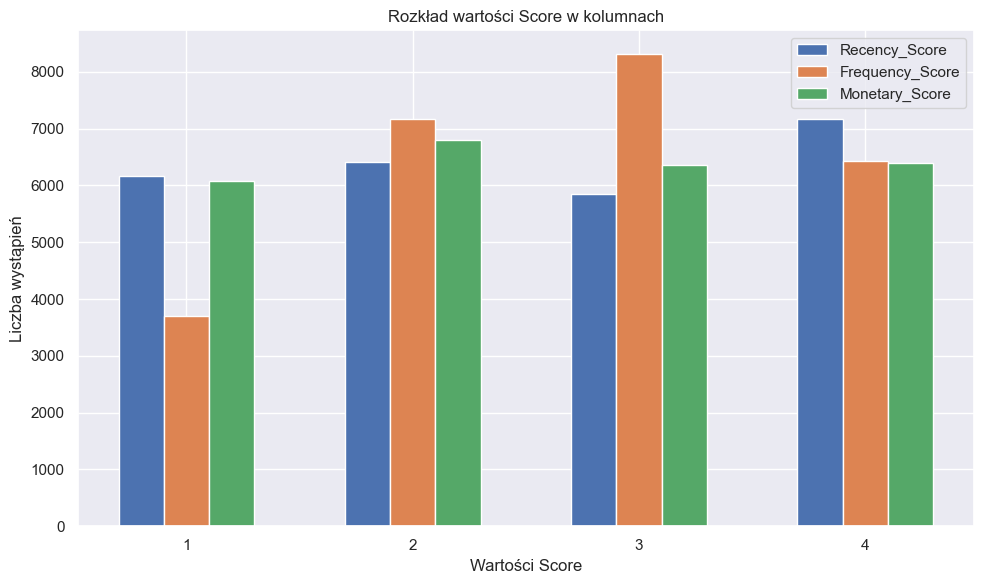

In [26]:
# Obliczanie liczności wartości dla każdej kolumny
recency_counts = df_RFM['Recency_Score'].value_counts().sort_index()
frequency_counts = df_RFM['Frequency_Score'].value_counts().sort_index()
monetary_counts = df_RFM['Monetary_Score'].value_counts().sort_index()

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.bar(recency_counts.index - 0.2, recency_counts.values, width=0.2, label='Recency_Score', align='center')
plt.bar(frequency_counts.index, frequency_counts.values, width=0.2, label='Frequency_Score', align='center')
plt.bar(monetary_counts.index + 0.2, monetary_counts.values, width=0.2, label='Monetary_Score', align='center')

# Dodanie etykiet i tytułu
plt.xlabel('Wartości Score')
plt.ylabel('Liczba wystąpień')
plt.title('Rozkład wartości Score w kolumnach')
plt.xticks(ticks=recency_counts.index, labels=recency_counts.index)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def rfm_scoring(customer):
    return str(int(customer['Recency_Score'])) + str(int(customer['Frequency_Score'])) + str(int(customer['Monetary_Score']))


df_RFM['Customer_RFM_Score'] = df_RFM.apply(rfm_scoring, axis=1)
df_RFM.sample(8)

,user_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Customer_RFM_Score
10805,542551313,13,2,13.02,3,2,2,322
1049,308509490,22,3,12.73,2,2,2,222
18310,582783059,25,9,26.21,1,4,3,143
24856,592922227,5,6,7.95,4,3,1,431
12391,555767750,14,27,355.58,3,4,4,344
1322,334220789,15,2,6.03,3,2,1,321
23416,590510226,10,6,22.99,3,3,2,332
6551,486966369,20,3,10.14,2,2,1,221


In [28]:
df_RFM['RFM_Label'] = df_RFM['Recency_Score'] + df_RFM['Frequency_Score'] + df_RFM['Monetary_Score']

df_RFM.sample(8)

,user_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Customer_RFM_Score,RFM_Label
24569,592360649,6,1,3.00,4,1,1,411,6
13272,561629737,13,7,28.41,3,3,3,333,9
15013,572244346,16,1,30.95,2,1,3,213,6
17029,580873811,25,6,18.48,1,3,2,132,6
24087,591578101,5,15,89.49,4,4,4,444,12
11353,547847390,22,10,34.34,2,4,3,243,9
17305,581364008,28,1,12.22,1,1,2,112,4
17244,581287525,28,4,38.45,1,3,3,133,7


In [29]:
segments = {'Customer_Segment':['Champion', 
                                'Top Loyal Customer', 
                                'Loyal Customer', 
                                'Top Recent Customer', 
                                'Recent Customer', 
                                'Top Customer Needed Attention', 
                                'Customer Needed Attention', 
                                'Top Lost Customer', 
                                'Lost Customer'],
            'RFM':['(2|3|4)-(4)-(4)', 
                   '(3)-(1|2|3|4)-(3|4)', 
                   '(3)-(1|2|3|4)-(1|2)', 
                   '(4)-(1|2|3|4)-(3|4)', 
                   '(4)-(1|2|3|4)-(1|2)',
                   '(2|3)-(1|2|3|4)-(3|4)', 
                   '(2|3)-(1|2|3|4)-(1|2)',
                   '(1)-(1|2|3|4)-(3|4)', 
                   '(1)-(1|2|3|4)-(1|2)',]}

pd.DataFrame(segments)

,Customer_Segment,RFM
0,Champion,(2|3|4)-(4)-(4)
1,Top Loyal Customer,(3)-(1|2|3|4)-(3|4)
2,Loyal Customer,(3)-(1|2|3|4)-(1|2)
3,Top Recent Customer,(4)-(1|2|3|4)-(3|4)
4,Recent Customer,(4)-(1|2|3|4)-(1|2)
5,Top Customer Needed Attention,(2|3)-(1|2|3|4)-(3|4)
6,Customer Needed Attention,(2|3)-(1|2|3|4)-(1|2)
7,Top Lost Customer,(1)-(1|2|3|4)-(3|4)
8,Lost Customer,(1)-(1|2|3|4)-(1|2)


In [30]:
def categorizer(rfm):
    
    if (rfm[0] in ['2', '3', '4']) & (rfm[1] in ['4']) & (rfm[2] in ['4']):
        rfm = 'Champion'
        
    elif (rfm[0] in ['3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Loyal Customer'
        
    elif (rfm[0] in ['3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Loyal Customer'
    
    elif (rfm[0] in ['4']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Recent Customer'
    
    elif (rfm[0] in ['4']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Recent Customer'
    
    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Customer Needed Attention'    
   
    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Customer Needed Attention'
    
    elif (rfm[0] in ['1']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Lost Customer'
                
    elif (rfm[0] in ['1']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Lost Customer'
    
    return rfm

In [31]:
df_RFM['Customer_Category'] = df_RFM["Customer_RFM_Score"].apply(categorizer)
df_RFM

,user_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Customer_RFM_Score,RFM_Label,Customer_Category
0,12055855,11,4,16.54,3,3,2,332,8,Loyal Customer
1,15400971,18,3,35.71,2,2,3,223,7,Top Customer Needed Attention
2,25392526,13,3,22.14,3,2,2,322,7,Loyal Customer
3,28129653,21,13,42.85,2,4,4,244,10,Champion
4,31647175,2,2,15.88,4,2,2,422,8,Recent Customer
...,...,...,...,...,...,...,...,...,...,...
25608,595367593,0,4,21.27,4,3,2,432,9,Recent Customer
25609,595372293,0,2,42.54,4,2,4,424,10,Top Recent Customer
25610,595373694,0,1,19.83,4,1,2,412,7,Recent Customer
25611,595376179,0,9,46.49,4,4,4,444,12,Champion


In [32]:
df_RFM['Customer_Category'].value_counts(dropna=False, normalize=True)*100

Customer_Category
Recent Customer                  13.821106
Customer Needed Attention        12.622496
Lost Customer                    12.286729
Top Lost Customer                11.790887
Loyal Customer                   11.513684
Champion                         11.298950
Top Recent Customer               9.729434
Top Customer Needed Attention     8.796314
Top Loyal Customer                8.140397
Name: proportion, dtype: float64

In [33]:
Size_RFM_Label = df_RFM['Customer_Category'].value_counts()
Size_RFM_Label_df = pd.DataFrame(Size_RFM_Label)
Size_RFM_Label_df.head()

,count
Customer_Category,
Recent Customer,3540
Customer Needed Attention,3233
Lost Customer,3147
Top Lost Customer,3020
Loyal Customer,2949


In [35]:
fig = px.treemap(Size_RFM_Label_df, 
                 path=[Size_RFM_Label_df.index], 
                 values='count', 
                 width=950, height=600)

fig.update_layout(title_text='The Size of Each Customer Segments',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
# Do pobrania user_id (docelowo maile)

# Ręczna definicja ścieżki do folderu
selected_folder = "ścieka do folderu lokalnego"

# Sprawdzenie, czy folder istnieje
if not os.path.exists(selected_folder):
    print(f"Folder '{selected_folder}' nie istnieje. Upewnij się, że podałeś poprawną ścieżkę.")
else:
    # Zapis plików do wybranego folderu
    for category, group in df_RFM.groupby('Customer_Category'):
        filename = os.path.join(selected_folder, f"{category.replace(' ', '_').lower()}_users.csv")
        group[['user_id']].to_csv(filename, index=False)

    print(f"Pliki zostały zapisane w folderze: {selected_folder}")

Pliki zostały zapisane w folderze: /Users/iMac/Documents/Dataparapa/jdszr16-datapaparapa/user_id_export
